# Installing Dependencies

**Installing MNE package for python**

In [ ]:
!pip install mne
!pip install mne_features


     |████████████████████████████████| 7.4 MB 3.6 MB/s 
     |████████████████████████████████| 40 kB 2.6 MB/s 
  Created wheel for mne-features: filename=mne_features-0.2-py3-none-any.whl size=26763 sha256=0c3f786326a277b9df91fb049355a9fb9d08f4dd1e16d466494375999f12c588
  Stored in directory: /root/.cache/pip/wheels/50/7d/94/905a24736d6d8ecd07fb249d02af5391afed5054d26a0b66b8
Successfully built mne-features


**Mounting Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Libraries**

In [ ]:
import mne
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import ShuffleSplit, cross_val_score,KFold
from mne.decoding import CSP
from mne_features.feature_extraction import extract_features





# Dataset and Information Extraction

**Importing dataset**

In [ ]:
filepath = '/content/drive/MyDrive/clients/mne/dataset/BCICIV_calib_ds1d.mat'

In [ ]:
dat= loadmat(filepath,struct_as_record=True)


In [ ]:
#sampling frequency
sam_freq = dat['nfo']['fs'][0][0][0][0]

#eeg signal information
EEG_data   = dat['cnt'].T
#extracting channel names and samples from eeg data shape
nchannels, nsamples = EEG_data.shape

#collecting channel names from dataset
chan_names = [s[0] for s in dat['nfo']['clab'][0][0][0]]

#event onsets and codes
event_onsets  = dat['mrk'][0][0][0]
event_codes   = dat['mrk'][0][0][1]

#defining a numppy zero arrays for class labels
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

#collecting class labels from dataset info
cl_lab = [s[0] for s in dat['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# electrode position digitization
x_pos = dat['nfo']['xpos']
y_pos = dat['nfo']['ypos']

#number of classes equivalent to length of cl_lab 
nclasses = len(cl_lab)
#number of events equivalent to length of event_onsets
nevents = len(event_onsets)

# information about dataset
print('Shape of EEG:', EEG_data.shape)
print('Sample rate:', sam_freq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [ ]:
# to store trails 
trials = {}

#time window for extracting each trails
win = np.arange(int(0.5*sam_freq), int(2.5*sam_freq))

# time window length
nsamples = len(win)

# Looping over classes 
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # onsets for the class extraction
    cl_onsets = event_onsets[event_codes == code]
    
    # for trails,allocating memeory
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # each trail extraction
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG_data[:, win+onset]
        
# trails dimesionality 
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [ ]:
#collecting left and right from trials and applying roll axis to acquare the accurate shape for mne epoch data
left  = np.rollaxis(trials[cl1], 2, 0)  
right= np.rollaxis(trials[cl2], 2, 0)  


In [ ]:
#creating data to  get epochs using it  
data = np.concatenate([left, right])

In [ ]:
# create labels 
Y = np.concatenate([-np.ones(left.shape[0]),
                     np.ones(right.shape[0])])

In [ ]:
#number of channels
n_channels = 59

#defining info 
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*nchannels,
        sfreq    = sam_freq )  

print('Event created :', info)  

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [ ]:
# electrode position 
x_pos = dat['nfo']['xpos'][0][0]  
y_pos = dat['nfo']['ypos'][0][0] 

In [ ]:
layout_pos = np.concatenate([x_pos, y_pos], axis = 1)
layout_pos

array([[-0.20109028,  0.68656518],
       [ 0.20109028,  0.68656518],
       [-0.48547489,  0.52547424],
       [-0.32894737,  0.46520183],
       [-0.16535231,  0.43208641],
       [ 0.        ,  0.421549  ],
       [ 0.16535231,  0.43208641],
       [ 0.32894737,  0.46520183],
       [ 0.48547489,  0.52547424],
       [-0.60591541,  0.27165704],
       [-0.39919579,  0.23384348],
       [-0.19765935,  0.21394494],
       [ 0.        ,  0.20773757],
       [ 0.19765935,  0.21394494],
       [ 0.39919579,  0.23384348],
       [ 0.60591541,  0.27165704],
       [-0.74834683,  0.15177169],
       [-0.52472976,  0.12553103],
       [-0.30963911,  0.11086096],
       [-0.10226303,  0.10426648],
       [ 0.10226303,  0.10426648],
       [ 0.30963911,  0.11086096],
       [ 0.52472976,  0.12553103],
       [ 0.74834683,  0.15177169],
       [-0.87719298,  0.        ],
       [-0.64569058,  0.        ],
       [-0.421549  ,  0.        ],
       [-0.20773757,  0.        ],
       [ 0.        ,

In [ ]:
#creating layout using layout positions using x_pos and y_pos 
layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names=chan_names,
    name ='Layout of EEG',
    )

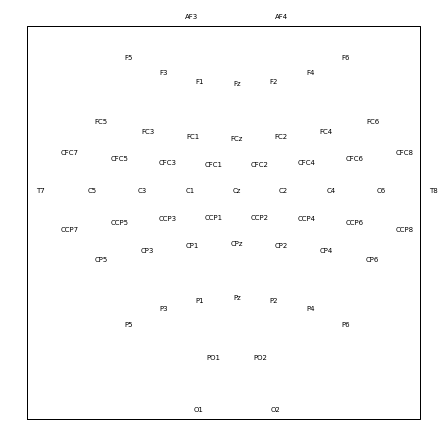

In [ ]:
#visualize the layout of channels
layout.plot();

In [ ]:
#defingin a dictionary for event id . In this case we have two events
event_id = dict(left = -1, right = 1)

In [ ]:
# Altering events with event code
eventLength = Y.shape[0]
ev = [i*sam_freq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

In [ ]:
#defining tmin for time window for each trail
tmin = 0.5                
# Create ecpochs using our extracted info and data
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [ ]:
#define a variable called final data to perform preprocessing
final_data = epochs


# Preprocessing Section

**Remove drifts**

In [ ]:
#highpass filter removes slow drifts. so we pass our data to a highpass filter
final_data = final_data.filter(1., None, fir_design='firwin')

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)



<ipython-input-117-cab7ab3e7e2c>:2: RuntimeWarning: filter_length (331) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  final_data = final_data.filter(1., None, fir_design='firwin')


    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-118-472a5d8fd72f>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  final_data.plot_psd(area_mode='range', tmax=10.0,  average=False)


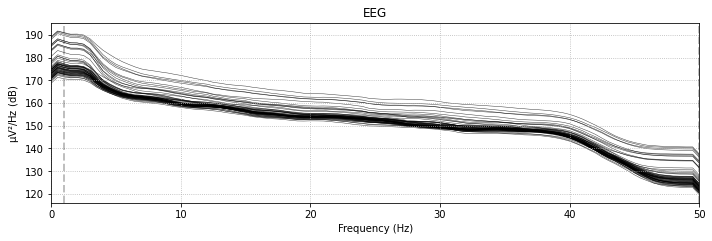

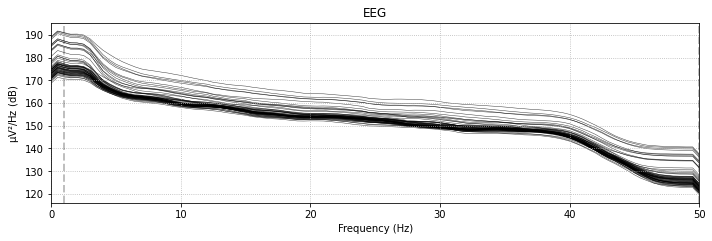

In [ ]:
#ploting power singnal density 
final_data.plot_psd(area_mode='range', tmax=10.0,  average=False)

**Finding bad channel**

In [ ]:
final_data.info['bads']
#no bad channel found

[]

** **Re Referencing**

In [ ]:
#Rereferencing using bipolar referencing scheme. 
final_data = mne.set_bipolar_reference(final_data,chan_names,chan_names)

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
AF3-AF3, AF4-AF4, F5-F5, F3-F3, F1-F1, Fz-Fz, F2-F2, F4-F4, F6-F6, FC5-FC5, FC3-FC3, FC1-FC1, FCz-FCz, FC2-FC2, FC4-FC4, FC6-FC6, CFC7-CFC7, CFC5-CFC5, CFC3-CFC3, CFC1-CFC1, CFC2-CFC2, CFC4-CFC4, CFC6-CFC6, CFC8-CFC8, T7-T7, C5-C5, C3-C3, C1-C1, Cz-Cz, C2-C2, C4-C4, C6-C6, T8-T8, CCP7-CCP7, CCP5-CCP5, CCP3-CCP3, CCP1-CCP1, CCP2-CCP2, CCP4-CCP4, CCP6-CCP6, CCP8-CCP8, CP5-CP5, CP3-CP3, CP1-CP1, CPz-CPz, CP2-CP2, CP4-CP4, CP6-CP6, P5-P5, P3-P3, P1-P1, Pz-Pz, P2-P2, P4-P4, P6-P6, PO1-PO1, PO2-PO2, O1-O1, O2-O2


    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-121-364a6f071f6f>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  final_data.plot_psd(area_mode='range', tmax=10.0,  average=False)


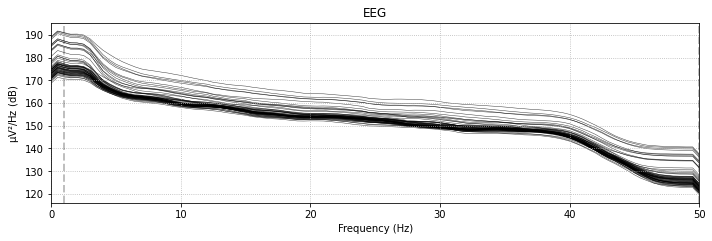

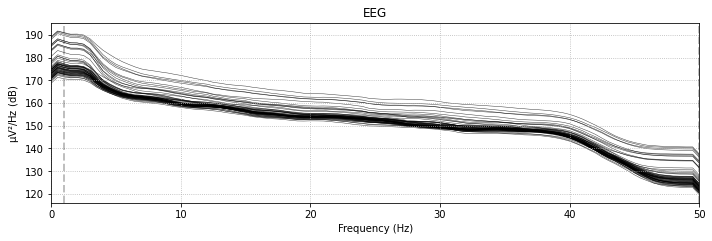

In [ ]:
#ploting after re-referncing
final_data.plot_psd(area_mode='range', tmax=10.0,  average=False)

**Filtering Using Given Range**

In [ ]:
#filter our data with 8-28 Hz
final_data = final_data.filter(8,28)

Setting up band-pass filter from 8 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 165 samples (1.650 sec)



    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-123-694c881245f2>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  final_data.plot_psd(area_mode='range', tmax=10.0,  average=False)


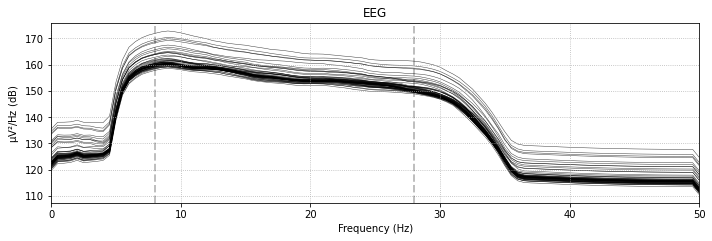

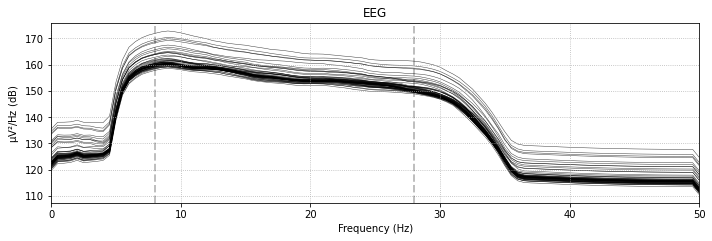

In [ ]:
#ploting after passing via a custom filter of 8-28Hz
final_data.plot_psd(area_mode='range', tmax=10.0,  average=False)

In [ ]:
#get our prepossed data into epochs variable
epochs = final_data

In [ ]:
#create training by copying epochs
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

**Compute and visualize ERDS**

In [ ]:
#Here we set suitable values for computing ERDS maps.
freqs = np.arange(8, 28)  # frequencies 
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1.5)  # min, center, and max ERDS


Not setting metadata
No baseline correction applied
No baseline correction applied
No baseline correction applied


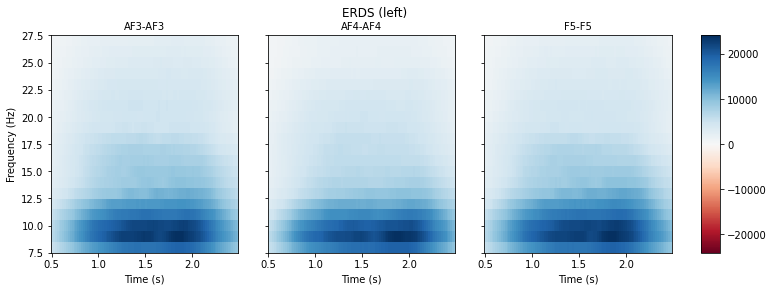

No baseline correction applied
No baseline correction applied
No baseline correction applied


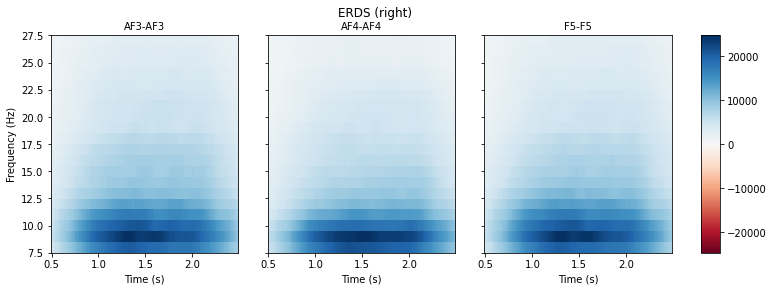

In [ ]:
#time/frequency decomposition over all epochs.
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)


for event in event_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel


        # plot TFR (ERDS map)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False)

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle(f"ERDS ({event})")
    plt.show()

# Feature Extraction and Classification

In [ ]:
# defining three classifier
lda = LinearDiscriminantAnalysis()
lgr = LogisticRegression()
svm = SVC()
selected_funcs = {'mean', 'ptp_amp', 'std'}
#Extracting features of EEG data using csp
csp = CSP(n_components=4, reg=None, log=True)


# cross validation to reduce variance
cv = ShuffleSplit(1, test_size=0.2)
#cv = KFold(n_splits=1)
#array to store results of two classifier
scores_one = []
scores_two = []
scores_three = []

#getting epochs data for classifictioan
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

#features extraction 
new_data = extract_features(epochs_data_train, sam_freq, selected_funcs)







In [ ]:
# perform and evaluate lda using pipeline 
clf_one = Pipeline([('CSP', csp), ('LDA', lda)])
scores_one = cross_val_score(clf_one, epochs_data_train, labels,cv =cv,  n_jobs=1)




Computing rank from data with rank=None
    Using tolerance 3.2e+02 (2.2e-16 eps * 59 dim * 2.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


In [ ]:
# Result of LDA classification
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores_one),
                                                          class_balance))

Classification accuracy: 0.825000 / Chance level: 0.500000


In [ ]:
#perform logisticregression and storing accuracy  using pipeline
clf_two = Pipeline([('CSP', csp), ('LGR', lgr)])
scores_two = cross_val_score(clf_two, epochs_data_train, labels,cv =cv,  n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 3.2e+02 (2.2e-16 eps * 59 dim * 2.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


In [ ]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores_two),
                                                          class_balance))

Classification accuracy: 0.850000 / Chance level: 0.500000


In [ ]:
# perform and evaluate svc using pipeline 
clf_three = Pipeline([('CSP', csp), ('SVC', svm)])
scores_three = cross_val_score(clf_three, epochs_data_train, labels,cv =cv,  n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 3.2e+02 (2.2e-16 eps * 59 dim * 2.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


In [ ]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores_three),
                                                          class_balance))

Classification accuracy: 0.900000 / Chance level: 0.500000


# Newly added Feature Extraction using user defined function

In [ ]:
from scipy.signal import medfilt

import mne
from mne.datasets import sample

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from mne_features.feature_extraction import FeatureExtractor

In [ ]:
def compute_medfilt(arr):

    return medfilt(arr, kernel_size=(1, 5)).ravel()

In [ ]:
selected_funcs = [('medfilt', compute_medfilt), 'mean']

pipe_one = Pipeline([('fe', FeatureExtractor(sfreq=sam_freq,
                                         selected_funcs=selected_funcs)),
                 ('scaler', StandardScaler()),
                 ('clf',lda)])
pipe_two = Pipeline([('fe', FeatureExtractor(sfreq=sam_freq,
                                         selected_funcs=selected_funcs)),
                 ('scaler', StandardScaler()),
                 ('clf',lgr)])
pipe_three = Pipeline([('fe', FeatureExtractor(sfreq=sam_freq,
                                         selected_funcs=selected_funcs)),
                 ('scaler', StandardScaler()),
                 ('clf',svm)])

y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, y, test_size=0.1)
accuracy_one = pipe_one.fit(X_train, y_train).score(X_test, y_test)
accuracy_two = pipe_two.fit(X_train, y_train).score(X_test, y_test)
accuracy_three = pipe_three.fit(X_train, y_train).score(X_test, y_test)
print('Accuracy score of LDA = %1.3f' % accuracy_one)
print('Accuracy score of Lgr = %1.3f' % accuracy_two)
print('Accuracy score of svm = %1.3f' % accuracy_three)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy score of LDA = 0.500
Accuracy score of Lgr = 0.550
Accuracy score of svm = 0.600
